In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 178 kB 8.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641372 sha256=723b618b659412cdb815e40cff655e5221d44b1d78cd2ef14fe8848ab9f332f6
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
import datetime

In [ ]:
def model_forecast(threshold, forecast_period, df):

    # Preparing data
    data = df.copy()
    data['date'] = pd.to_datetime(data['date'], dayfirst=True)
    index = data['date']
    data = data.drop(columns=['date'])
    data.index = index
    data['ds'] = data.index
    data.rename(columns={'value': 'y'}, inplace=True)

    # Building model
    model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5, seasonality_prior_scale=0.01, changepoint_range=0.8)
    model.add_seasonality(name='weekly', period=7, fourier_order=2, prior_scale=0.1)
    model.add_seasonality(name='custom_monthly', period=30.5, fourier_order=5)
    model.add_country_holidays(country_name='RU')

    # Fitting model
    model.fit(data)

    # Predicting
    period = model.make_future_dataframe(periods=int(forecast_period[:-1]), freq='M', include_history=False)['ds'].values[-1]
    period = int((period - np.datetime64(threshold, 'D')).astype('timedelta64[D]') / np.timedelta64(1, 'D'))
    future = model.make_future_dataframe(periods=period, freq='D', include_history=False)
    forecast = model.predict(future)

    # Finding stable part
    stable_part = forecast['yhat'].min()
    stable_part_arr = np.array([stable_part] * len(future))
    future['stable_part'] = stable_part_arr

    # Plotting results
    model.plot(forecast);
    ax = (data.plot(x='ds', y='y', figsize=(20, 5), title='Actual Vs Forecast'))
    forecast.plot(x='ds', y='yhat', figsize=(20, 5), title='Actual vs Forecast', ax=ax)
    future.plot(x='ds', y='stable_part', figsize=(20, 5), title='Actual Vs Forecast', ax=ax)
    plt.show()

    return stable_part

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


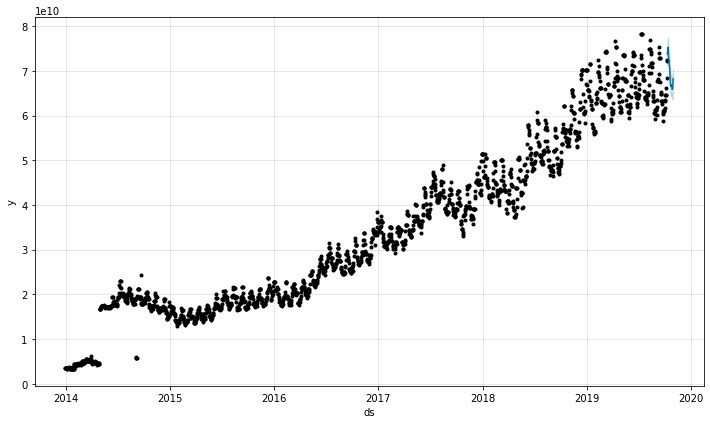

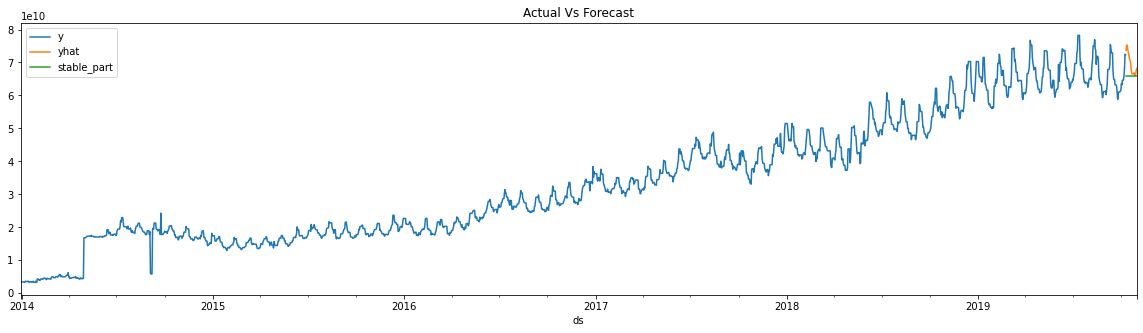

In [ ]:
df = pd.read_csv('data.csv', sep=';', skiprows=1, names=['date', 'value'])
stable = model_forecast('2019-10-10', '1M', df)